<a href="https://colab.research.google.com/github/zacharyedwardsong/USC-Research-Proj/blob/main/Orientation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Base

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch.optim as optim
import pandas as pd
import math
import random as gen
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [ ]:
def CardinalDirection(p1, p2 = (0, 0)): #Defaults to comparing to origin
  if (p1[0] == p2[0] and p1[1] == p2[1]): #Same point
    return 0
  elif (p1[0] == p2[0]):
    if (p1[1] > p2[0]): #North
      return 1
    else: #South
      return 2
  elif (p1[1] == p2[1]):
    if (p1[0] > p2[0]): #East
      return 3
    else: #West
      return 4
  elif (p1[0] > p2[0]):
    if (p1[1] > p2[1]): #NorthEast
      return 5
    else: #SouthEast
      return 6
  else:
    if (p1[1] > p2[1]): #NorthWest
      return 7
    else: #SouthWest
      return 8
# [0] Same point, [1] North, [2] South, [3] East, [4] West, [5] NorthEast, [6] SouthEast, [7] NorthWest, [8] SouthWest

In [ ]:
class NonEncodingMLP(nn.Module):
  def __init__(self, input_features, h1, dropout_probability, output_features=9):
    super(NonEncodingMLP, self).__init__()
    self.fc1 = nn.Linear(input_features, h1)
    self.fc2 = nn.Linear(h1 * 2, 9)
    self.softmax = nn.Softmax()
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(p = dropout_probability)

  def forward(self, p1, p2): #Outputs direction of p2 to p1
    #512, 2
    p1 = self.relu(self.fc1(p1))
    p2 = self.relu(self.fc1(p2))
    #512, 2*h1
    comb = torch.cat((p1, p2), dim=1) #https://www.enthought.com/blog/deep-learning-extracting/
    comb = self.relu(self.fc2(comb))
    comb = self.softmax(comb)
    #Shape: [512, 9]
    # print(comb.detach().numpy().argmax())
    #activation func
    return comb

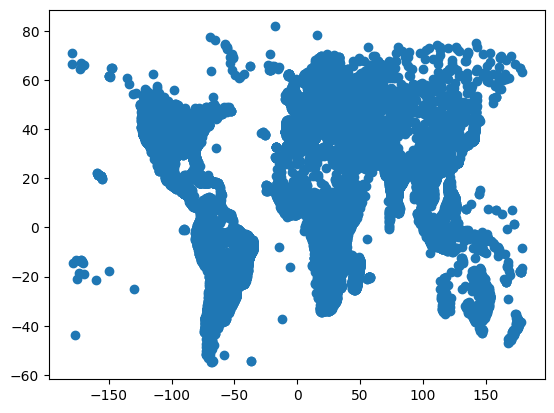

In [ ]:
data = pd.read_csv(r'/content/worldcities.csv')
X = data['lng']
Y = data['lat']
plt.scatter(X, Y)

points = []
for i in range(200):
  points.append((X[i], Y[i]))

gen.shuffle(points)

# split points in two groups
points_1 = points[:int(len(points)/2)]
points_2 = points[int(len(points)/2):]

locs = torch.Tensor(list(product(points_1, points_2)))

X_train, X_other = train_test_split(locs, train_size = 0.6)
X_val, X_test = train_test_split(X_other, test_size = 0.5)
train_dataloader = DataLoader(X_train, batch_size = 512, shuffle = True)
val_dataloader = DataLoader(X_val, batch_size = 128, shuffle = False)
test_dataloader = DataLoader(X_test, batch_size = 128, shuffle = False)

In [ ]:
base = NonEncodingMLP(input_features=2, h1=32, dropout_probability=0.3) # 6 per point; becomes 12 when concatenated

num_epochs = 100
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.Adam(base.parameters(), lr=0.0001, weight_decay=1e-6)

max_base_accuracy = 0
base_train_losses = []
base_val_losses = []
base_f1s = []
base_accuracies = []
base_recalls = []

for epoch in range(num_epochs):
  base.train()
  tloss = []
  for pair in (train_dataloader):
    pi = pair[:, 0, :]
    pj = pair[:, 1, :]
    prediction = base(pi, pj)
    # [512, 12] + [512, 12] = [1024, 12]
    true_prediction = []
    for i in range(len(pi)):
      true_prediction.append(CardinalDirection(pi[i], pj[i]))
    true_prediction = torch.tensor(true_prediction)
    loss = criterion(prediction, true_prediction.to(device))
    tloss.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  base_train_losses.append(np.mean(tloss))

  base.eval()
  val_loss = []
  y_true, y_pred, y_prob = [], [], []
  with torch.no_grad():
    for batch in val_dataloader:
      # get batch
      pi = batch[:, 0, :]
      pj = batch[:, 1, :]
      logits = base(pi, pj)
      output_probs = torch.softmax(logits, dim=-1).cpu().numpy()
      y_pred.extend(np.argmax(output_probs, axis=1))
      true_prediction = []
      for i in range(len(pi)):
        true_prediction.append(CardinalDirection(pi[i], pj[i]))
      true_prediction = torch.tensor(true_prediction)
      loss = criterion(logits, true_prediction)
      val_loss.append(loss.item())
      # compute metrics
      y_true.extend(true_prediction.cpu().numpy())
      y_prob.extend(output_probs)
  accuracy = accuracy_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred, average='weighted')
  precision = precision_score(y_true, y_pred, average='weighted')
  recall = recall_score(y_true, y_pred, average='weighted')

  if (precision > max_base_accuracy):
    max_base_accuracy = precision
    torch.save(base.state_dict(), 'model_weights.pth')
  print("Epoch: [{}/{}]".format(epoch, num_epochs))
  base_f1s.append(f1)
  base_accuracies.append(precision)
  base_recalls.append(recall)
  print("F1 Score: ", f1)
  print("Precision: ", precision)
  print("Recall [?]: ", recall)
  # base.eval()
  # with torch.no_grad():
  #     vloss = []
  #     correct_counter = 0
  #     total_counter = 0
  #     for val_points in (val_dataloader):
  #         # TODO: complete validation loop
  #       pi = val_points[:, 0, :]
  #       pj = val_points[:, 1, :]
  #       y_val = base(pi, pj)
  #       true_prediction = []
  #       for i in range(len(pi)):
  #         true_prediction.append(CardinalDirection(pi[i], pj[i]))
  #       total_counter = len(pi)
  #       true_prediction = torch.tensor(true_prediction)
  #       loss = criterion(y_val, true_prediction)
  #       vloss.append(loss.item())
  #       direction_index = 0
  #     for i in range(len(predicted_direction[0])):
  #       if (predicted_direction[0][i].item() > predicted_direction[0][direction_index].item()):
  #         direction_index = i
  #     if(np.mean(vloss).item() < min_base_loss):
  #       min_loss = np.mean(vloss).item()
  #       torch.save(base.state_dict(), 'base_weights.pth')
  #     print(f'Val Epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(vloss):.4f}')
  #     base_val_losses.append(np.mean(vloss))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include di

Epoch: [0/100]
F1 Score:  0.2294627987136651
Precision:  0.3955008506603076
Recall [?]:  0.298


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [1/100]
F1 Score:  0.26451779828042704
Precision:  0.4362046105951284
Recall [?]:  0.33


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [2/100]
F1 Score:  0.277381415193265
Precision:  0.4646923056587812
Recall [?]:  0.3425


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [3/100]
F1 Score:  0.31777403883353184
Precision:  0.6278747192531952
Recall [?]:  0.3795


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [4/100]
F1 Score:  0.4257456651761472
Precision:  0.6905656619993582
Recall [?]:  0.512


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [5/100]
F1 Score:  0.4306977604837423
Precision:  0.6524053350538647
Recall [?]:  0.538


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [6/100]
F1 Score:  0.46726248236995027
Precision:  0.6923580105537186
Recall [?]:  0.573


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [7/100]
F1 Score:  0.4768038393200328
Precision:  0.6604804284326913
Recall [?]:  0.5895


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [8/100]
F1 Score:  0.48960914528790433
Precision:  0.6400716400259447
Recall [?]:  0.597


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [9/100]
F1 Score:  0.500840735059365
Precision:  0.6540332460433411
Recall [?]:  0.603


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [10/100]
F1 Score:  0.5291682217402771
Precision:  0.667864631722552
Recall [?]:  0.6175


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [11/100]
F1 Score:  0.5422863074827692
Precision:  0.6596009809370883
Recall [?]:  0.6175


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [12/100]
F1 Score:  0.5885270818321406
Precision:  0.6958282209792436
Recall [?]:  0.6495


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [13/100]
F1 Score:  0.6272628067065029
Precision:  0.7284751227803283
Recall [?]:  0.6815


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [14/100]
F1 Score:  0.6432855542097855
Precision:  0.7419410482653382
Recall [?]:  0.695


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [15/100]
F1 Score:  0.6446458792812215
Precision:  0.7200804975488359
Recall [?]:  0.6955


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [16/100]
F1 Score:  0.6795302008861471
Precision:  0.7436013020434403
Recall [?]:  0.7245


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [17/100]
F1 Score:  0.700760018888171
Precision:  0.7405636395935182
Recall [?]:  0.731


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [18/100]
F1 Score:  0.7156966701494154
Precision:  0.7418446423564695
Recall [?]:  0.7395


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [19/100]
F1 Score:  0.7311651707400947
Precision:  0.7609451351627924
Recall [?]:  0.752


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [20/100]
F1 Score:  0.7535956492722322
Precision:  0.7799037977001867
Recall [?]:  0.7685


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [21/100]
F1 Score:  0.7688780981734686
Precision:  0.7930293244505373
Recall [?]:  0.783


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [22/100]
F1 Score:  0.7819684088157847
Precision:  0.8009063395291232
Recall [?]:  0.7915


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [23/100]
F1 Score:  0.7757609099616082
Precision:  0.8040714701492907
Recall [?]:  0.787


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [24/100]
F1 Score:  0.8090188265456837
Precision:  0.8253971758808515
Recall [?]:  0.816


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [25/100]
F1 Score:  0.8019429717168477
Precision:  0.8234233102583446
Recall [?]:  0.8105


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [26/100]
F1 Score:  0.8129212282530088
Precision:  0.8305777531030476
Recall [?]:  0.82


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [27/100]
F1 Score:  0.806079753704249
Precision:  0.8255350156357885
Recall [?]:  0.814


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [28/100]
F1 Score:  0.8171817855061565
Precision:  0.8318481875999894
Recall [?]:  0.8235


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [29/100]
F1 Score:  0.8022632130181844
Precision:  0.8228168475332143
Recall [?]:  0.811


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [30/100]
F1 Score:  0.8210901909509419
Precision:  0.8341424900192722
Recall [?]:  0.827


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [31/100]
F1 Score:  0.8141033657453342
Precision:  0.8322879329444791
Recall [?]:  0.822


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [32/100]
F1 Score:  0.8148283267552315
Precision:  0.83109170315604
Recall [?]:  0.822


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [33/100]
F1 Score:  0.8099745321212308
Precision:  0.8278943811966782
Recall [?]:  0.8165


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [34/100]
F1 Score:  0.8173153506987044
Precision:  0.8341545293865616
Recall [?]:  0.824
Epoch: [35/100]
F1 Score:  0.8168663287022228
Precision:  0.8326302750869815
Recall [?]:  0.8235


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [36/100]
F1 Score:  0.82063357018324
Precision:  0.83514034734038
Recall [?]:  0.827


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [37/100]
F1 Score:  0.8210344213925491
Precision:  0.8352779479604413
Recall [?]:  0.8275


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [38/100]
F1 Score:  0.8207093636503088
Precision:  0.8363935198795687
Recall [?]:  0.8275


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [39/100]
F1 Score:  0.8213393399714546
Precision:  0.8362998064516416
Recall [?]:  0.828


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [40/100]
F1 Score:  0.8262383471419847
Precision:  0.8389383536280629
Recall [?]:  0.832


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [41/100]
F1 Score:  0.8256852893700667
Precision:  0.84313891382711
Recall [?]:  0.8325


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [42/100]
F1 Score:  0.8200497920162286
Precision:  0.8356799273069443
Recall [?]:  0.8265


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [43/100]
F1 Score:  0.8365223348001372
Precision:  0.8470704125870353
Recall [?]:  0.8415


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [44/100]
F1 Score:  0.8261461396591847
Precision:  0.8421964684821968
Recall [?]:  0.8325


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [45/100]
F1 Score:  0.8337225804163813
Precision:  0.8450061102112575
Recall [?]:  0.839


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [46/100]
F1 Score:  0.8352825754210638
Precision:  0.8462943087835475
Recall [?]:  0.84


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [47/100]
F1 Score:  0.8373267672648522
Precision:  0.8490715611667425
Recall [?]:  0.8425


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [48/100]
F1 Score:  0.8321501127551097
Precision:  0.8440890535993657
Recall [?]:  0.8375


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [49/100]
F1 Score:  0.8395587873603991
Precision:  0.8507998501633875
Recall [?]:  0.8445


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [50/100]
F1 Score:  0.8415328498183082
Precision:  0.8514455775564691
Recall [?]:  0.846


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [51/100]
F1 Score:  0.8354144501456496
Precision:  0.8493484023872485
Recall [?]:  0.841


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [52/100]
F1 Score:  0.8410523430469345
Precision:  0.8528555628340578
Recall [?]:  0.846


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [53/100]
F1 Score:  0.8412794596395936
Precision:  0.852005579374179
Recall [?]:  0.846


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [54/100]
F1 Score:  0.851731694050918
Precision:  0.8598963698883769
Recall [?]:  0.8555


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [55/100]
F1 Score:  0.8377121361367916
Precision:  0.8508837095538135
Recall [?]:  0.843


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [56/100]
F1 Score:  0.8389009455379379
Precision:  0.8511810588730935
Recall [?]:  0.844


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [57/100]
F1 Score:  0.8432243313677402
Precision:  0.8536778116217899
Recall [?]:  0.8475


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [58/100]
F1 Score:  0.8473356199389958
Precision:  0.8575946605970357
Recall [?]:  0.8515


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [59/100]
F1 Score:  0.848951865530515
Precision:  0.8584727972147559
Recall [?]:  0.853


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [60/100]
F1 Score:  0.836806111438787
Precision:  0.8489735478431271
Recall [?]:  0.8415


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [61/100]
F1 Score:  0.8580371466646377
Precision:  0.865279904556554
Recall [?]:  0.8615


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [62/100]
F1 Score:  0.8490783272945933
Precision:  0.8584543353232382
Recall [?]:  0.853


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [63/100]
F1 Score:  0.857821450657017
Precision:  0.866315678043211
Recall [?]:  0.8615


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [64/100]
F1 Score:  0.8474439384451848
Precision:  0.8573025187887621
Recall [?]:  0.8515


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [65/100]
F1 Score:  0.8660926313329774
Precision:  0.8719247895547456
Recall [?]:  0.869


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [66/100]
F1 Score:  0.8545755520936652
Precision:  0.863788408664134
Recall [?]:  0.8585


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [67/100]
F1 Score:  0.8501920065451777
Precision:  0.8609766743463834
Recall [?]:  0.8545


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [68/100]
F1 Score:  0.8653444425936251
Precision:  0.8719693822624502
Recall [?]:  0.8685


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [69/100]
F1 Score:  0.8707234945082586
Precision:  0.8787860007872198
Recall [?]:  0.874


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [70/100]
F1 Score:  0.8733691724566919
Precision:  0.8815100863604539
Recall [?]:  0.8765


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [71/100]
F1 Score:  0.8631065304947196
Precision:  0.8752837677566602
Recall [?]:  0.867


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [72/100]
F1 Score:  0.868992699741799
Precision:  0.882657556274155
Recall [?]:  0.8735


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [73/100]
F1 Score:  0.8929080966449593
Precision:  0.8996003198445669
Recall [?]:  0.8955


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [74/100]
F1 Score:  0.8719232779200049
Precision:  0.8865056449694388
Recall [?]:  0.8765


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [75/100]
F1 Score:  0.89212302691268
Precision:  0.8993837412898729
Recall [?]:  0.8945


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [76/100]
F1 Score:  0.8831929052300894
Precision:  0.8934797267881478
Recall [?]:  0.8865


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [77/100]
F1 Score:  0.8719379993973473
Precision:  0.88833787147825
Recall [?]:  0.8765


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [78/100]
F1 Score:  0.8982040347588849
Precision:  0.9051798021736194
Recall [?]:  0.9005


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [79/100]
F1 Score:  0.8813291312022768
Precision:  0.8939046816554556
Recall [?]:  0.885


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [80/100]
F1 Score:  0.8811860588324852
Precision:  0.893879083411507
Recall [?]:  0.885


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [81/100]
F1 Score:  0.8816396738594533
Precision:  0.8952889249331704
Recall [?]:  0.8855


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [82/100]
F1 Score:  0.8826450769703097
Precision:  0.8962930168631988
Recall [?]:  0.8865


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [83/100]
F1 Score:  0.897021205604727
Precision:  0.9043546372659718
Recall [?]:  0.8995


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [84/100]
F1 Score:  0.8792861889480277
Precision:  0.8951473383821811
Recall [?]:  0.8835


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [85/100]
F1 Score:  0.904662605892274
Precision:  0.9122351067609163
Recall [?]:  0.907


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [86/100]
F1 Score:  0.8879551218987725
Precision:  0.9004017627874498
Recall [?]:  0.8915


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [87/100]
F1 Score:  0.8932970445970227
Precision:  0.9051417262906085
Recall [?]:  0.8965


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [88/100]
F1 Score:  0.8894431777836637
Precision:  0.902314179081541
Recall [?]:  0.893


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [89/100]
F1 Score:  0.9043522942236307
Precision:  0.9123651374605786
Recall [?]:  0.9065


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [90/100]
F1 Score:  0.8853128508196952
Precision:  0.8993671756810164
Recall [?]:  0.889


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [91/100]
F1 Score:  0.8995477429002063
Precision:  0.9093741301210654
Recall [?]:  0.902


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [92/100]
F1 Score:  0.8959020508707317
Precision:  0.9071191089601476
Recall [?]:  0.899


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [93/100]
F1 Score:  0.9116325654253017
Precision:  0.91737135282695
Recall [?]:  0.9135


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [94/100]
F1 Score:  0.8936149860365065
Precision:  0.9056792153768694
Recall [?]:  0.897


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [95/100]
F1 Score:  0.8981482535195621
Precision:  0.9091406525513901
Recall [?]:  0.901


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [96/100]
F1 Score:  0.9012516641819444
Precision:  0.9122589739096159
Recall [?]:  0.904


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [97/100]
F1 Score:  0.8973298269443987
Precision:  0.9075384872824631
Recall [?]:  0.9


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [98/100]
F1 Score:  0.9176593205790066
Precision:  0.9241845470207009
Recall [?]:  0.9195


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: [99/100]
F1 Score:  0.9089524121427153
Precision:  0.9169027820334537
Recall [?]:  0.911


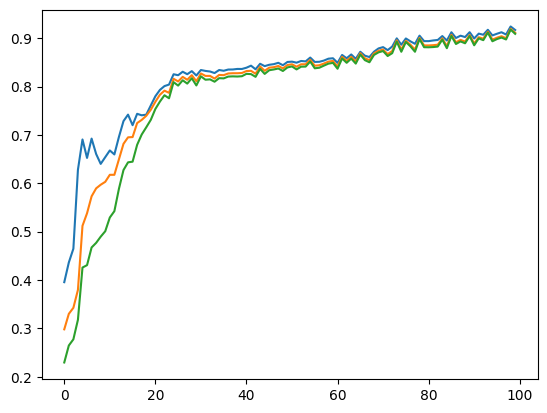

In [ ]:
plt.plot(range(num_epochs), base_accuracies)
plt.plot(range(num_epochs), base_recalls)
plt.plot(range(num_epochs), base_f1s)

In [ ]:
base.load_state_dict(torch.load('model_weights.pth'))
total = 0
counter = 0
base_test_losses = []

with torch.no_grad():
  for test_pair in (test_dataloader):
    pi = test_pair[:, 0, :]
    pj = test_pair[:, 1, :]
    y_test = base(pi, pj)
    true_prediction = []
    for i in range(len(pi)):
      true_prediction.append(CardinalDirection(pi[i], pj[i]))
    true_prediction = torch.tensor(true_prediction)
    loss = criterion(y_test, true_prediction)
    base_test_losses.append(loss)

print("\nLoss of base model: ", np.mean(base_test_losses))


Loss of base model:  1.5239377


<ipython-input-11-615e135c5f57>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  base.load_state_dict(torch.load('model_weights.pth'))
/usr/local/lib/python3.10/dist-package

In [ ]:
while True:
  try:
    x, y = map(float, input(f"Enter current location (x y): ").split())
    curr = torch.tensor((x, y)).unsqueeze(0)
    break
  except ValueError:
    print("Invalid input. Please enter two numerical values separated by a space.")
while True:
  try:
    x, y = map(float, input(f"Enter destination (x y): ").split())
    dest = torch.tensor((x, y)).unsqueeze(0)
    break
  except ValueError:
    print("Invalid input. Please enter two numerical values separated by a space.")

predicted_direction = base(dest, curr)
direction_index = 0
for i in range(len(predicted_direction[0])):
  if (predicted_direction[0][i].item() > predicted_direction[0][direction_index].item()):
    direction_index = i
# [0] Same point, [1] North, [2] South, [3] East, [4] West, [5] NorthEast, [6] SouthEast, [7] NorthWest, [8] SouthWest
direction = "Same point"
if (direction_index == 1):
  direction = "North"
elif (direction_index == 2):
  direction = "South"
elif (direction_index == 3):
  direction = "East"
elif (direction_index == 4):
  direction = "West"
elif (direction_index == 5):
  direction = "NorthEast"
elif (direction_index == 6):
  direction = "SouthEast"
elif (direction_index == 7):
  direction = "NorthWest"
elif (direction_index == 8):
  direction = "SouthWest"
print("\nPredicted direction: ", direction)
direction = CardinalDirection((dest[0][0].item(), dest[0][1].item()), (curr[0][0].item(), curr[0][1].item()))
if (direction == 0):
  direction = "Null"
elif (direction == 1):
  direction = "North"
elif (direction == 2):
  direction = "South"
elif (direction == 3):
  direction = "East"
elif (direction == 4):
  direction = "West"
elif (direction == 5):
  direction = "NorthEast"
elif (direction == 6):
  direction = "SouthEast"
elif (direction == 7):
  direction = "NorthWest"
elif (direction == 8):
  direction = "SouthWest"
print("True direction: ", direction)

Enter current location (x y): (0, 0)
Invalid input. Please enter two numerical values separated by a space.
Enter current location (x y): 0 0
Enter destination (x y): 1 1

Predicted direction:  NorthEast
True direction:  NorthEast


# Encoding

In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self, input_features, h1, dropout_probability, output_features=9):
      super(SimpleMLP, self).__init__()
      self.fc1 = nn.Linear(input_features, h1)
      self.fc2 = nn.Linear(h1 * 2, 9)
      self.softmax = nn.Softmax()
      self.relu = nn.ReLU()
      self.dropout = nn.Dropout(p = dropout_probability)

    def forward(self, p1, p2):
      #512, 2
      p1 = self.relu(self.fc1(p1))
      p2 = self.relu(self.fc1(p2))
      #512, 2*h1
      comb = torch.cat((p1, p2), dim=1) #https://www.enthought.com/blog/deep-learning-extracting/
      comb = self.relu(self.fc2(comb))
      comb = self.softmax(comb)
      #Shape: [512, 9]
      # print(comb.detach().numpy().argmax())
      #activation func
      return comb
class PointSpaceEncoder(nn.Module):
    """A vectorized Point Space Encoder of Space2Vec.

    This model takes a batch of 2D coordinates and outputs one d-dimentional vector for each.
    Equation 3 of https://arxiv.org/pdf/2003.00824.pdf.
    Set lambdas and n_scales (i.e. S) according to Section 5.2 of https://arxiv.org/pdf/2003.00824.pdf

    Args:
        lambda_min: The minimum scale to be considered.
        lambda_max: The maximum scale to be considered.
        n_scales: The number of scales (`S` in Space2Vec) between lambda_min and lambda_max.
        d_hid: The dimension of the hidden layer.
        d_output: The dimension of the output vectors.
    """

    def __init__(self, model, lambda_min=1, lambda_max=10, n_scales=6):
        super().__init__()
        self.lambda_min = lambda_min
        self.lambda_max = lambda_max
        self.g = lambda_max / lambda_min
        self.S = n_scales
        self.MLP = model

        scales = torch.arange(n_scales).reshape(1, n_scales)
        self.scales = torch.nn.Parameter(scales, requires_grad=False)

        a1 = torch.tensor([1, 0])
        a2 = torch.tensor([-1/2, torch.sqrt(torch.tensor(3))/2])
        a3 = torch.tensor([-1/2, -torch.sqrt(torch.tensor(3))/2])
        a = torch.stack([a1, a2, a3])  # (3, 2)
        self.a = torch.nn.Parameter(a, requires_grad=False)

    def encode(self, x):
        """
        Args:
            x: pytorch float tensor of shape (batch size, 2), that represents a point

        Returns:
            loc_emb: pytorch float tensor of shape (batch size, 36), that represents the encoded vector
        """
        nominator = (x @ self.a.T).unsqueeze(-1)  # (..., 3, 1)
        denominator = self.lambda_min * torch.pow(self.g, self.scales / self.S - 1)
        fraction = nominator / denominator  # (..., 3, n_scales)
        fraction = fraction.reshape(*fraction.shape[:-2], -1)  # (..., 3*n_scales)
        PE_sj = torch.concatenate([torch.cos(fraction), torch.sin(fraction)], axis=-1)  # (..., 6*n_scales)
        return PE_sj

    def forward(self, p1, p2):
      """
      Args:
          p1: pytorch float tensor of shape (batch size, 2), that represents a point
          p2: pytorch float tensor of shape (batch size, 2), that represents a point
      Returns:
          distance: the computed distance between the location embeddings of p1 and p2
      """
      # first encode the two points
      enc1 = self.encode(p1)
      enc2 = self.encode(p2)
      # now given the encoded sequences compute their embeddings
      return self.MLP(enc1, enc2)

In [ ]:
points = []
for i in range(200):
  points.append((X[i], Y[i]))

gen.shuffle(points)

# split points in two groups
points_1 = points[:int(len(points)/2)]
points_2 = points[int(len(points)/2):]

locs = torch.Tensor(list(product(points_1, points_2)))

X_train, X_other = train_test_split(locs, train_size = 0.6)
X_val, X_test = train_test_split(X_other, test_size = 0.5)
train_dataloader = DataLoader(X_train, batch_size = 512, shuffle = True)
val_dataloader = DataLoader(X_val, batch_size = 128, shuffle = False)
test_dataloader = DataLoader(X_test, batch_size = 128, shuffle = False)

encoder_network = SimpleMLP(input_features=36, h1=32, dropout_probability=0.3).to(device) # 6 per point; becomes 12 when concatenated
encoder = PointSpaceEncoder(encoder_network)

num_epochs = 100
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.Adam(base.parameters(), lr=0.0001, weight_decay=1e-6)

min_encoder_loss = 1000000000
encoder_train_losses = []
encoder_val_losses = []
encoder_f1s = []
encoder_accuracies = []
encoder_recalls = []

for epoch in range(num_epochs):
  encoder.train()
  tloss = []
  for pair in (train_dataloader):
    pi = pair[:, 0, :]
    pj = pair[:, 1, :]
    prediction = encoder(pi, pj)
    # [512, 12] + [512, 12] = [1024, 12]
    true_prediction = []
    for i in range(len(pi)):
      true_prediction.append(CardinalDirection(pi[i], pj[i]))
    true_prediction = torch.tensor(true_prediction)
    loss = criterion(prediction, true_prediction.to(device))
    tloss.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print(f'Train Epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(tloss):.4f}')
  encoder_train_losses.append(np.mean(tloss))

  encoder.eval()
  vloss = []
  y_true, y_pred, y_prob = [], [], []
  with torch.no_grad():
    for batch in val_dataloader:
      # get batch
      pi = batch[:, 0, :]
      pj = batch[:, 1, :]
      logits = base(pi, pj)
      output_probs = torch.softmax(logits, dim=-1).cpu().numpy()
      y_pred.extend(np.argmax(output_probs, axis=1))
      true_prediction = []
      for i in range(len(pi)):
        true_prediction.append(CardinalDirection(pi[i], pj[i]))
      true_prediction = torch.tensor(true_prediction)
      loss = criterion(logits, true_prediction)
      val_loss.append(loss.item())
      # compute metrics
      y_true.extend(true_prediction.cpu().numpy())
      y_prob.extend(output_probs)
  accuracy = accuracy_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred, average='weighted')
  precision = precision_score(y_true, y_pred, average='weighted')
  recall = recall_score(y_true, y_pred, average='weighted')
  encoder_f1s.append(f1)
  encoder_accuracies.append(precision)
  encoder_recalls.append(recall)
  print("F1 Score: ", f1)
  print("Precision: ", precision)
  print("Recall [?]: ", recall)

Train Epoch [1/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [2/100], Loss: 2.1988
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [3/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [4/100], Loss: 2.1988
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [5/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [6/100], Loss: 2.1988
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [7/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [8/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [9/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [10/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [11/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [12/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [13/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [14/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [15/100], Loss: 2.1987


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265
Train Epoch [16/100], Loss: 2.1988


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265
Train Epoch [17/100], Loss: 2.1987


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265
Train Epoch [18/100], Loss: 2.1987


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265
Train Epoch [19/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [20/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [21/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [22/100], Loss: 2.1988
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [23/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [24/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [25/100], Loss: 2.1988
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [26/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [27/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [28/100], Loss: 2.1988
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [29/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [30/100], Loss: 2.1988
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [31/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [32/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [33/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [34/100], Loss: 2.1988
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [35/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [36/100], Loss: 2.1988
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [37/100], Loss: 2.1988
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [38/100], Loss: 2.1987


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265
Train Epoch [39/100], Loss: 2.1988


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265
Train Epoch [40/100], Loss: 2.1987


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265
Train Epoch [41/100], Loss: 2.1987


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265
Train Epoch [42/100], Loss: 2.1988
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [43/100], Loss: 2.1988
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [44/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [45/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [46/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [47/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [48/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [49/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [50/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [51/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [52/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [53/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [54/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [55/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [56/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [57/100], Loss: 2.1988
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [58/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [59/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [60/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [61/100], Loss: 2.1987


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265
Train Epoch [62/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [63/100], Loss: 2.1987


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265
Train Epoch [64/100], Loss: 2.1987


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265
Train Epoch [65/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [66/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [67/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [68/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [69/100], Loss: 2.1988
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [70/100], Loss: 2.1988
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [71/100], Loss: 2.1988
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [72/100], Loss: 2.1988
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [73/100], Loss: 2.1988
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [74/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [75/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [76/100], Loss: 2.1988
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [77/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [78/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [79/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [80/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [81/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [82/100], Loss: 2.1988
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [83/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [84/100], Loss: 2.1988
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [85/100], Loss: 2.1987


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265
Train Epoch [86/100], Loss: 2.1987


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265
Train Epoch [87/100], Loss: 2.1988


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265
Train Epoch [88/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [89/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [90/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [91/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [92/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [93/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [94/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [95/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [96/100], Loss: 2.1988
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [97/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [98/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [99/100], Loss: 2.1987
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch [100/100], Loss: 2.1988
F1 Score:  0.9252734941144081
Precision:  0.931034353946084
Recall [?]:  0.9265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Experiment

In [ ]:
temp = np.zeros((512, 9))
temp = torch.tensor(temp)
print(temp)
np.argmax(temp)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)


tensor(0)